In [1]:
import numpy as np 
import random
import matplotlib.pyplot as plt # Graphical library
from sklearn.metrics import mean_squared_error # Mean-squared error function
from collections import defaultdict

# Maze Solving by Reinforcement Learning

## Helper class

In [3]:
class GraphicsMaze(object):

    def __init__(self, shape, locations, default_reward, obstacle_locs, absorbing_locs, absorbing_rewards, absorbing):

        self.shape = shape
        self.locations = locations
        self.absorbing = absorbing

        # Walls
        self.walls = np.zeros(self.shape)
        for ob in obstacle_locs:
            self.walls[ob] = 20

        # Rewards
        self.rewarders = np.ones(self.shape) * default_reward
        for i, rew in enumerate(absorbing_locs):
            self.rewarders[rew] = 10 if absorbing_rewards[i] > 0 else -10

        # Print the map to show it
        self.paint_maps()

    def paint_maps(self):
        """
        Print the Maze topology (obstacles, absorbing states and rewards)
        input: /
        output: /
        """
        plt.figure(figsize=(15,10))
        plt.imshow(self.walls + self.rewarders)
        plt.show()

    def paint_state(self, state):
        """
        Print one state on the Maze topology (obstacles, absorbing states and rewards)
        input: /
        output: /
        """
        states = np.zeros(self.shape)
        states[state] = 30
        plt.figure(figsize=(15,10))
        plt.imshow(self.walls + self.rewarders + states)
        plt.show()

    def draw_deterministic_policy(self, Policy):
        """
        Draw a deterministic policy
        input: Policy {np.array} -- policy to draw (should be an array of values between 0 and 3 (actions))
        output: /
        """
        plt.figure(figsize=(15,10))
        plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
        for state, action in enumerate(Policy):
            if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
                continue
            arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
            action_arrow = arrows[action] # Take the corresponding action
            location = self.locations[state] # Compute its location on graph
            plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
        plt.show()

    def draw_policy(self, Policy):
        """
        Draw a policy (draw an arrow in the most probable direction)
        input: Policy {np.array} -- policy to draw as probability
        output: /
        """
        deterministic_policy = np.array([np.argmax(Policy[row,:]) for row in range(Policy.shape[0])])
        self.draw_deterministic_policy(deterministic_policy)

    def draw_value(self, Value):
        """
        Draw a policy value
        input: Value {np.array} -- policy values to draw
        output: /
        """
        plt.figure(figsize=(15,10))
        plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
        for state, value in enumerate(Value):
            if(self.absorbing[0, state]): # If it is an absorbing state, don't plot any value
                continue
            location = self.locations[state] # Compute the value location on graph
            plt.text(location[1], location[0], round(value,2), ha='center', va='center') # Place it on graph
        plt.show()

    def draw_deterministic_policy_grid(self, Policies, title, n_columns, n_lines):
        """
        Draw a grid representing multiple deterministic policies
        input: Policies {np.array of np.array} -- array of policies to draw (each should be an array of values between 0 and 3 (actions))
        output: /
        """
        plt.figure(figsize=(20,8))
        for subplot in range (len(Policies)): # Go through all policies
            ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each policy
            ax.imshow(self.walls+self.rewarders) # Create the graph of the Maze
            for state, action in enumerate(Policies[subplot]):
                if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
                    continue
                arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
                action_arrow = arrows[action] # Take the corresponding action
                location = self.locations[state] # Compute its location on graph
                plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
            ax.title.set_text(title[subplot]) # Set the title for the graph given as argument
        plt.show()
    

    def draw_policy_grid(self, Policies, title, n_columns, n_lines):
        """
        Draw a grid representing multiple policies (draw an arrow in the most probable direction)
        input: Policy {np.array} -- array of policies to draw as probability
        output: /
        """
        deterministic_policies = np.array([[np.argmax(Policy[row,:]) for row in range(Policy.shape[0])] for Policy in Policies])
        self.draw_deterministic_policy_grid(deterministic_policies, title, n_columns, n_lines)

    def draw_value_grid(self, Values, title, n_columns, n_lines):
        """
        Draw a grid representing multiple policy values
        input: Values {np.array of np.array} -- array of policy values to draw
        output: /
        """
        plt.figure(figsize=(20,8))
        for subplot in range (len(Values)): # Go through all values
            ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each value
            ax.imshow(self.walls+self.rewarders) # Create the graph of the Maze
            for state, value in enumerate(Values[subplot]):
                if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
                    continue
                location = self.locations[state] # Compute the value location on graph
                plt.text(location[1], location[0], round(value,1), ha='center', va='center') # Place it on graph
            ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
        plt.show()
    
        


## Maze class

In [4]:
class Maze(object):

    def __init__(self):
        """
        Maze initialisation.
        input: /
        output: /
        """
        self._prob_success = 0.98
        self._gamma = 0.8
        self._goal = 1

        # Build the maze
        self._build_maze()
                              
    def _build_maze(self):
        """
        Maze initialisation.
        input: /
        output: /
        """

        # Properties of the maze
        self._shape = (13, 10)
        self._obstacle_locs = [
                              (1,0), (1,1), (1,2), (1,3), (1,4), (1,7), (1,8), (1,9), \
                              (2,1), (2,2), (2,3), (2,7), \
                              (3,1), (3,2), (3,3), (3,7), \
                              (4,1), (4,7), \
                              (5,1), (5,7), \
                              (6,5), (6,6), (6,7), \
                              (8,0), \
                              (9,0), (9,1), (9,2), (9,6), (9,7), (9,8), (9,9), \
                              (10,0)
                             ] # Location of obstacles
        self._absorbing_locs = [(2,0), (2,9), (10,1), (12,9)] # Location of absorbing states
        self._absorbing_rewards = [ (500 if (i == self._goal) else -50) for i in range (4) ]
        self._starting_locs = [(0,0), (0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8), (0,9)] #Reward of absorbing states
        self._default_reward = -1 # Reward for each action performs in the environment
        self._max_t = 500 # Max number of steps in the environment

        # Actions
        self._action_size = 4
        self._direction_names = ['N','E','S','W'] # Direction 0 is 'N', 1 is 'E' and so on

        # States
        self._locations = []
        for i in range (self._shape[0]):
            for j in range (self._shape[1]):
                loc = (i,j) 
                # Adding the state to locations if it is no obstacle
                if self._is_location(loc):
                    self._locations.append(loc)
        self._state_size = len(self._locations)

        # Neighbours - each line is a state, ranked by state-number, each column is a direction (N, E, S, W)
        self._neighbours = np.zeros((self._state_size, 4)) 

        for state in range(self._state_size):
            loc = self._get_loc_from_state(state)

            # North
            neighbour = (loc[0]-1, loc[1]) # North neighbours location
            if self._is_location(neighbour):
                self._neighbours[state][self._direction_names.index('N')] = self._get_state_from_loc(neighbour)
            else: # If there is no neighbour in this direction, coming back to current state
                self._neighbours[state][self._direction_names.index('N')] = state

            # East
            neighbour = (loc[0], loc[1]+1) # East neighbours location
            if self._is_location(neighbour):
                self._neighbours[state][self._direction_names.index('E')] = self._get_state_from_loc(neighbour)
            else: # If there is no neighbour in this direction, coming back to current state
                self._neighbours[state][self._direction_names.index('E')] = state

            # South
            neighbour = (loc[0]+1, loc[1]) # South neighbours location
            if self._is_location(neighbour):
                self._neighbours[state][self._direction_names.index('S')] = self._get_state_from_loc(neighbour)
            else: # If there is no neighbour in this direction, coming back to current state
                self._neighbours[state][self._direction_names.index('S')] = state

            # West
            neighbour = (loc[0], loc[1]-1) # West neighbours location
            if self._is_location(neighbour):
                self._neighbours[state][self._direction_names.index('W')] = self._get_state_from_loc(neighbour)
            else: # If there is no neighbour in this direction, coming back to current state
                self._neighbours[state][self._direction_names.index('W')] = state

        # Absorbing
        self._absorbing = np.zeros((1, self._state_size))
        for a in self._absorbing_locs:
            absorbing_state = self._get_state_from_loc(a)
            self._absorbing[0, absorbing_state] = 1

        # Transition matrix
        self._T = np.zeros((self._state_size, self._state_size, self._action_size)) # Empty matrix of domension S*S*A
        for action in range(self._action_size):
            for outcome in range(4): # For each direction (N, E, S, W)
                # The agent has prob_success probability to go in the correct direction
                if action == outcome:
                    prob = 1 - 3.0 * ((1.0 - self._prob_success) / 3.0) # (theoritically equal to self.prob_success but avoid rounding error and garanty a sum of 1)
                # Equal probability to go into one of the other directions
                else:
                    prob = (1.0 - self._prob_success) / 3.0

                # Write this probability in the transition matrix
                for prior_state in range(self._state_size):
                    # If absorbing state, probability of 0 to go to any other states
                    if not self._absorbing[0, prior_state]:
                        post_state = self._neighbours[prior_state, outcome] # Post state number
                        post_state = int(post_state) # Transform in integer to avoid error
                        self._T[prior_state, post_state, action] += prob

        # Reward matrix
        self._R = np.ones((self._state_size, self._state_size, self._action_size)) # Matrix filled with 1
        self._R = self._default_reward * self._R # Set default_reward everywhere
        for i in range(len(self._absorbing_rewards)): # Set absorbing states rewards
            post_state = self._get_state_from_loc(self._absorbing_locs[i])
            self._R[:,post_state,:] = self._absorbing_rewards[i]

        # Creating the graphical Maze world
        self._graphics = GraphicsMaze(self._shape, self._locations, self._default_reward, self._obstacle_locs, self._absorbing_locs, self._absorbing_rewards, self._absorbing)

        # Reset the environment
        self.reset()


    def _is_location(self, loc):
        """
        Is the location a valid state (not out of Maze and not an obstacle)
        input: loc {tuple} -- location of the state
        output: _ {bool} -- is the location a valid state
        """
        if (loc[0] < 0 or loc[1] < 0 or loc[0] > self._shape[0]-1 or loc[1] > self._shape[1]-1):
            return False
        elif (loc in self._obstacle_locs):
            return False
        else:
            return True


    def _get_state_from_loc(self, loc):
        """
        Get the state number corresponding to a given location
        input: loc {tuple} -- location of the state
        output: index {int} -- corresponding state number
        """
        return self._locations.index(tuple(loc))


    def _get_loc_from_state(self, state):
        """
        Get the state number corresponding to a given location
        input: index {int} -- state number
        output: loc {tuple} -- corresponding location
        """
        return self._locations[state]

    def get_T(self):
        return self._T

    def get_R(self):
        return self._R

    def get_absorbing(self):
        return self._absorbing

    def get_graphics(self):
        return self._graphics

    def get_action_size(self):
        return self._action_size

    def get_state_size(self):
        return self._state_size

    def get_gamma(self):
        return self._gamma

    # Functions used to perform episodes in the Maze environment
    def reset(self):
        """
        Reset the environment state to one of the possible starting states
        input: /
        output: 
          - t {int} -- current timestep
          - state {int} -- current state of the envionment
          - reward {int} -- current reward
          - done {bool} -- True if reach a terminal state / 0 otherwise
        """
        self._t = 0
        self._state = self._get_state_from_loc(self._starting_locs[random.randrange(len(self._starting_locs))])
        self._reward = 0
        self._done = False
        return self._t, self._state, self._reward, self._done

    def step(self, action):
        """
        Perform an action in the environment
        input: action {int} -- action to perform
        output: 
          - t {int} -- current timestep
          - state {int} -- current state of the envionment
          - reward {int} -- current reward
          - done {bool} -- True if reach a terminal state / 0 otherwise
        """

        # If environment already finished, print an error
        if self._done or self._absorbing[0, self._state]:
            print("Please reset the environment")
            return self._t, self._state, self._reward, self._done

        # Drawing a random number used for probaility of next state
        probability_success = random.uniform(0,1)

        # Look for the first possible next states (so get a reachable state even if probability_success = 0)
        new_state = 0
        while self._T[self._state, new_state, action] == 0: 
            new_state += 1
        assert self._T[self._state, new_state, action] != 0, "Selected initial state should be probability 0, something might be wrong in the environment."

        # Find the first state for which probability of occurence matches the random value
        total_probability = self._T[self._state, new_state, action]
        while (total_probability < probability_success) and (new_state < self._state_size-1):
            new_state += 1
            total_probability += self._T[self._state, new_state, action]
        assert self._T[self._state, new_state, action] != 0, "Selected state should be probability 0, something might be wrong in the environment."

        # Setting new t, state, reward and done
        self._t += 1
        self._reward = self._R[self._state, new_state, action]
        self._done = self._absorbing[0, new_state] or self._t > self._max_t
        self._state = new_state
        return self._t, self._state, self._reward, self._done



## Dynamic Programming Agent

In [5]:
class DP_agent(object):

    def solve(self, env):
        """
        Solve a given Maze environment using Dynamic Programming
        input: env {Maze object} -- Maze to solve
        output: 
          - policy {np.array} -- Optimal policy found to solve the given Maze environment 
          - V {np.array} -- Corresponding value function 
        """
        
        # Initialisation (can be editedd)
        threshold = 0.0001

        policy = np.zeros((env.get_state_size(), env.get_action_size())).astype('int8')
        V = np.zeros(env.get_state_size())
        delta = threshold
        epochs = 0
        
        ### Value Iteration Method
        
        # stores np.argmax(Q) for every state, for policy update after while loop
        maxaction_idx = np.zeros((env.get_state_size(), 1)).astype('int8')
        
        converged = False
        
        while not converged:
            epochs += 1
            delta = 0 # Reinitialise delta value
            
            # Loop over each prior state
            for prior_state in range(env.get_state_size()):
                
                # Make sure prior state is not absorbing state
                if not env.get_absorbing()[0, prior_state]:
                    
                    old_v = V[prior_state] # store the old value for the state
                    Q = np.zeros([env.get_action_size(), 1]) # for storing Q values temporarily
                    
                    for action in range(env.get_action_size()): # loop over all action in each state
                        reward = np.expand_dims(env.get_R()[prior_state, :, action], axis=1)
                        reward_plus_v = reward + env.get_gamma() * np.expand_dims(V, axis=1)
                        prob = np.expand_dims(env.get_T()[prior_state, :, action], axis=0)
                        Q[action] = np.dot(prob, reward_plus_v)

                    V[prior_state] = np.max(Q) # Update V value to be the maximum Q value
                    maxaction_idx[prior_state] = np.argmax(Q) # save the index of the action with max Q value

                    # Update delta
                    delta = max(delta, np.abs(old_v - V[prior_state]))

            converged = True if delta < threshold else False # end loop only when delta is smaller than threshold
            
        # After the iteration loop finishes, update the optimal policy 
        for prior_state in range(env.get_state_size()):
            policy[prior_state, maxaction_idx[prior_state]] = 1
                    
        
        return policy, V

## Monte-Carlo agent

In [6]:
class MC_agent(object):

    def solve(self, env):
        """
        Solve a given Maze environment using Monte Carlo learning
        input: env {Maze object} -- Maze to solve
        output: 
          - policy {np.array} -- Optimal policy found to solve the given Maze environment 
          - values {list of np.array} -- List of successive value functions for each episode 
          - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
        """

        # Initialisation (can be edited)
        num_episode = 5000
        
        # initial parameters for reward-based epsilon-decay schedule
        epsilon = 0.5
        min_epsilon = 0.0
        reward_target = 100
        steps_to_take = reward_target
        reward_increment = 1
        reward_threshold = 0
        
        alpha = 0.1
        
        Q = np.random.rand(env.get_state_size(), env.get_action_size())# Q(s,a)
        V = np.zeros(env.get_state_size()) # V(s)
        values = [] # list of all V
        total_rewards = [] # list of all total non-discounted sum of reward for each episode

        ### MC control with epsilon-greedy policy
        
        # Initialise epsilon-soft policy:
        policy = np.ones((env.get_state_size(), env.get_action_size())) * epsilon / env.get_action_size()
        best_action = np.argmax(Q, axis=1) # 98x1 array to record index of best action for each state
        for state in range(env.get_state_size()):
            policy[state, best_action[state]] += (1.0 - epsilon) # update higher prob for greedy action with max(Q)
 

        for j in range(num_episode):  # repeat for each episode
            epsilon_delta = (epsilon - min_epsilon) / steps_to_take # update epsilon_delta

            # Generate episode - a list of (state, action, reward) tuples 
            episode = []
            _, state, _, _ = env.reset() # initial env all reset 
            done = False

            while not done: 
                probs = policy[state] # resetted state's actions 1x4 
                probs /= probs.sum() # normalise the prob (so it must sum to 1)
                action = np.random.choice(range(env.get_action_size()), p = probs) # select the action
            
                _, next_state, reward, done = env.step(action)
                episode.append((state, action, reward))
                state = next_state

            # update Q and V values for each step in an episode
            total_reward_epi = 0 
            for i in range(len(episode)): # loop over each (s, a, r) tuple
                state, action, reward = episode[i]
                sa_pair = (state, action)
                total_reward_epi += reward # add up all the non-discounted reward

                # First occurance of each (s,a) pair in the episode
                first_idx = next(i for i,x in enumerate(episode) if x[0] == state and x[1] == action)
                G = sum([x[2] * (env.get_gamma()**i) for i,x in enumerate(episode[first_idx:])]) # the discounted return G
                Q[state, action] += alpha * (G - Q[state, action]) # update Q
                V[state] += alpha * (G - V[state]) # update V
        
                # Update the policy for each state: 
                max_action = np.argmax(Q[state])
                if action == max_action:
                    policy[state, action] = (1.0 - epsilon) + (epsilon / env.get_action_size())
                else: 
                    policy[state, action] = epsilon / env.get_action_size()
                
            # update (reduce) epsilon value if exceed reward_threshold: 
            if epsilon > min_epsilon and total_reward_epi >= reward_threshold:
                epsilon = epsilon - epsilon_delta
                reward_threshold = reward_threshold + reward_increment
                
            total_rewards.append(total_reward_epi)
            values.append(V.copy())

        return policy, values, total_rewards
    
    
### another function just for investigating different epsilon and alpha
    def solve_param(self, env, epsilon, alpha):
        
        # Initialisation (can be edited)
        num_episode = 5000
        
        # initial constant epsilon and alpha 
        epsilon = epsilon
        alpha = alpha
        
        Q = np.random.rand(env.get_state_size(), env.get_action_size())# Q(s,a)
        V = np.zeros(env.get_state_size()) # V(s)
        values = [] # list of all V
        total_rewards = [] # list of all total non-discounted sum of reward for each episode

        ### MC control with epsilon-greedy policy
        
        # Initialise epsilon-soft policy:
        policy = np.ones((env.get_state_size(), env.get_action_size())) * epsilon / env.get_action_size()
        best_action = np.argmax(Q, axis=1) # 98x1 array to record index of best action for each state
        for state in range(env.get_state_size()):
            policy[state, best_action[state]] += (1.0 - epsilon) # update higher prob for greedy action with max(Q)
 

        for j in range(num_episode):  # repeat for each episode
        
            # Generate episode - a list of (state, action, reward) tuples 
            episode = []
            _, state, _, _ = env.reset() # initial env all reset 
            done = False

            while not done: 
                probs = policy[state] # resetted state's actions 1x4 
                probs /= probs.sum() # normalise the prob (so it must sum to 1)
                action = np.random.choice(range(env.get_action_size()), p = probs) # select the action
            
                _, next_state, reward, done = env.step(action)
                episode.append((state, action, reward))
                state = next_state

            # update Q and V values for each step in an episode
            total_reward_epi = 0 
            for i in range(len(episode)): # loop over each (s, a, r) tuple
                state, action, reward = episode[i]
                sa_pair = (state, action)
                total_reward_epi += reward # add up all the non-discounted reward

                # First occurance of each (s,a) pair in the episode
                first_idx = next(i for i,x in enumerate(episode) if x[0] == state and x[1] == action)
                G = sum([x[2] * (env.get_gamma()**i) for i,x in enumerate(episode[first_idx:])]) # the discounted return G
                Q[state, action] += alpha * (G - Q[state, action]) # update Q
                V[state] += alpha * (G - V[state]) # update V
        
                # Update the policy for each state: 
                max_action = np.argmax(Q[state])
                if action == max_action:
                    policy[state, action] = (1.0 - epsilon) + (epsilon / env.get_action_size())
                else: 
                    policy[state, action] = epsilon / env.get_action_size()
                
            total_rewards.append(total_reward_epi)
            values.append(V.copy())

        return policy, values, total_rewards

## Temporal Difference agent

In [7]:
class TD_agent(object):

    def solve(self, env):
        """
        Solve a given Maze environment using Temporal Difference learning
        input: env {Maze object} -- Maze to solve
        output: 
          - policy {np.array} -- Optimal policy found to solve the given Maze environment 
          - values {list of np.array} -- List of successive value functions for each episode 
          - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
        """

        # Initialisation (can be edited)
        Q = np.zeros((env.get_state_size(), env.get_action_size()))
        V = np.zeros(env.get_state_size())
        values = [] # list of all V
        total_rewards = [] # list of all total non-discounted sum of reward for each episode

        
        num_episode = 5000

        # initial parameters for reward-based epsilon-decay schedule
        epsilon = 0.5
        min_epsilon = 0.0
        reward_target = 100
        steps_to_take = reward_target
        reward_increment = 1
        reward_threshold = 0
        
        alpha = 0.1
        
        # Initialisation - epsilon-soft policy (arbitrary) - all zeros if Q = np.zeros
        policy = np.ones((env.get_state_size(), env.get_action_size())) * epsilon / env.get_action_size()
        best_action = np.argmax(Q, axis=1) # 98x1 array to record index of best action for each state
        for state in range(env.get_state_size()):
            policy[state, best_action[state]] += (1.0 - epsilon)
        
        for j in range(num_episode): # repeat for each episode
            epsilon_delta = (epsilon - min_epsilon) / steps_to_take # update epsilon_delta
            _, state, reward, _ = env.reset() # env reset 

            # pick the initial action based on the initialised policy
            probs = policy[state] 
            probs /= probs.sum() # normalise the prob
            action = np.random.choice(range(env.get_action_size()),p = probs)
    
            # repeat for each step to get (SARSA)
            total_reward_epi = 0
            done = False
            while not done: 
                _, next_state, reward, done = env.step(action) # get next state and reward
                total_reward_epi += reward # add all non-discounted rewards

                # pick the next action based on the next state from above
                probs = policy[next_state] 
                probs /= probs.sum()
                next_action = np.random.choice(range(env.get_action_size()),p = probs)
    
                # update Q and V
                Q[state, action] += alpha * (reward + (env.get_gamma() * Q[next_state, next_action]) - Q[state, action])
                V[state] += alpha * (reward + (env.get_gamma() * V[next_state]) - V[state])
                
                # update the greedy policy with picking action with max(Q)
                max_action = np.argmax(Q[state])
                if action == max_action:
                    policy[state, action] = (1.0 - epsilon) + (epsilon / env.get_action_size())
                else: 
                    policy[state, action] = epsilon / env.get_action_size()
                
                # update next state and next action to be current ones
                state = next_state
                action = next_action
            
            # update epsilon if reward exceed reward_threshold
            if epsilon > min_epsilon and total_reward_epi >= reward_threshold:
                epsilon = epsilon - epsilon_delta
                reward_threshold = reward_threshold + reward_increment
            
            total_rewards.append(total_reward_epi)
            values.append(V.copy())
            
        return policy, values, total_rewards
    
    
### another function just for investigating different epsilon and alpha
    def solve_param(self, env, epsilon, alpha):

        # Initialisation (can be edited)
        Q = np.zeros((env.get_state_size(), env.get_action_size()))
        V = np.zeros(env.get_state_size())
        values = [] # list of all V
        total_rewards = [] # list of all total non-discounted sum of reward for each episode

        
        num_episode = 5000

        # initialise constant epsilon and alpha
        epsilon = epsilon
        alpha = alpha
        
        # Initialisation - epsilon-soft policy (arbitrary) - all zeros if Q = np.zeros
        policy = np.ones((env.get_state_size(), env.get_action_size())) * epsilon / env.get_action_size()
        best_action = np.argmax(Q, axis=1) # 98x1 array to record index of best action for each state
        for state in range(env.get_state_size()):
            policy[state, best_action[state]] += (1.0 - epsilon)
        
        for j in range(num_episode): # repeat for each episode
            _, state, reward, _ = env.reset() # env reset 

            # pick the initial action based on the initialised policy
            probs = policy[state] 
            probs /= probs.sum() # normalise the prob
            action = np.random.choice(range(env.get_action_size()),p = probs)
    
            # repeat for each step to get (SARSA)
            total_reward_epi = 0
            done = False
            while not done: 
                _, next_state, reward, done = env.step(action) # get next state and reward
                total_reward_epi += reward # add all non-discounted rewards

                # pick the next action based on the next state from above
                probs = policy[next_state] 
                probs /= probs.sum()
                next_action = np.random.choice(range(env.get_action_size()),p = probs)
    
                # update Q and V
                Q[state, action] += alpha * (reward + (env.get_gamma() * Q[next_state, next_action]) - Q[state, action])
                V[state] += alpha * (reward + (env.get_gamma() * V[next_state]) - V[state])
                
                # update the greedy policy with picking action with max(Q)
                max_action = np.argmax(Q[state])
                if action == max_action:
                    policy[state, action] = (1.0 - epsilon) + (epsilon / env.get_action_size())
                else: 
                    policy[state, action] = epsilon / env.get_action_size()
                
                # update next state and next action to be current ones
                state = next_state
                action = next_action
           
            total_rewards.append(total_reward_epi)
            values.append(V.copy())
            
        return policy, values, total_rewards

## Main

Creating the Maze:



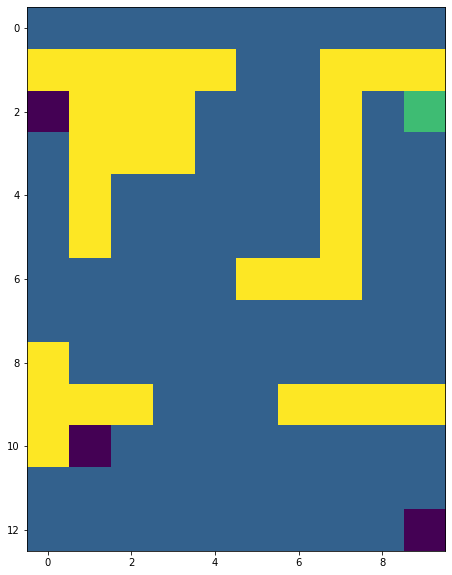

Probability of success:  0.98
Gamma:  0.8
Reward state:  1

Results of the DP agent:



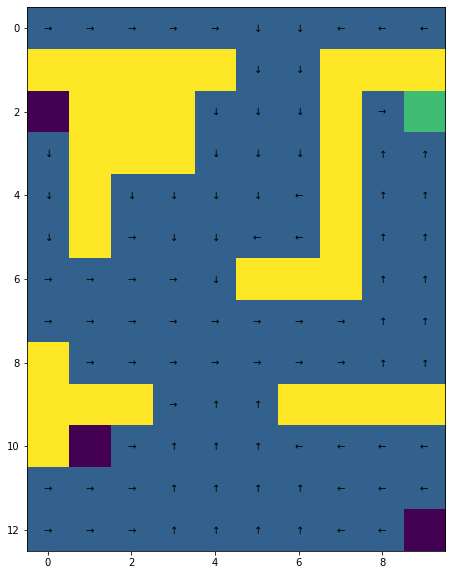

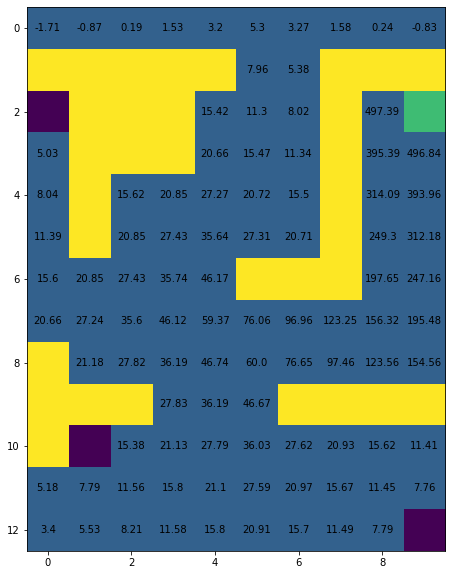

Results of the MC agent:



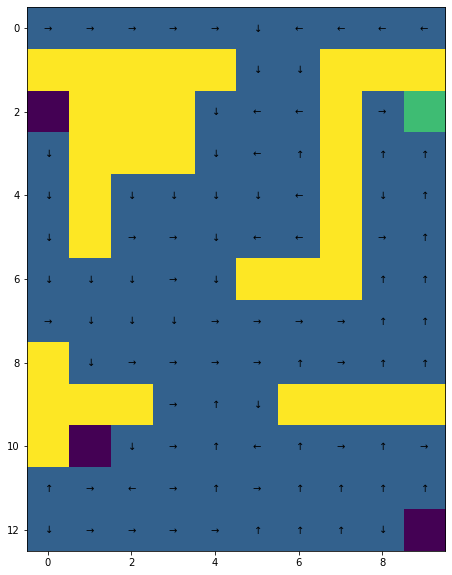

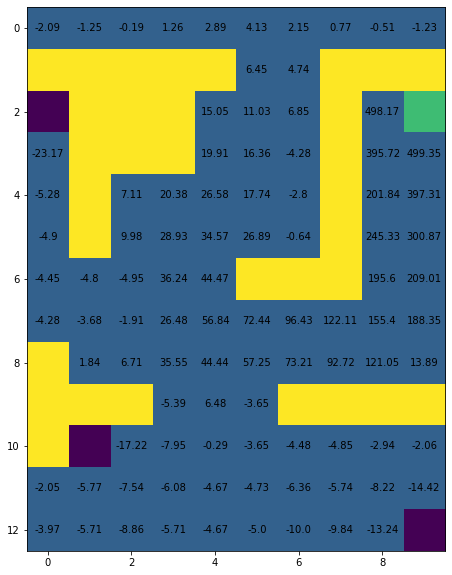

Results of the TD agent:



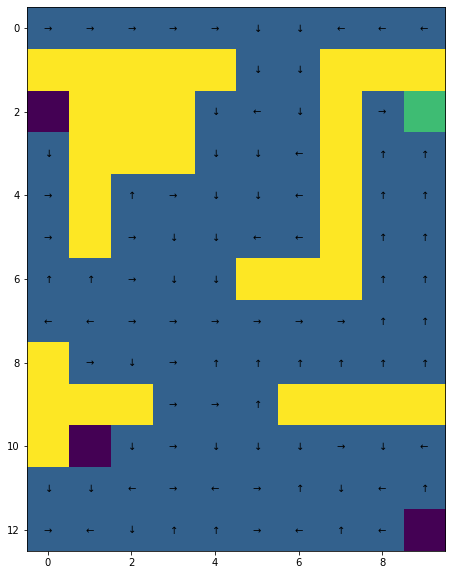

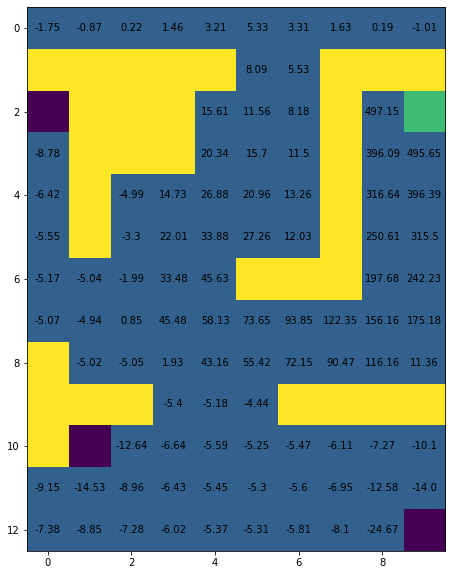

Replication:  0
Replication:  1
Replication:  2
Replication:  3
Replication:  4
Replication:  5
Replication:  6
Replication:  7
Replication:  8
Replication:  9
Replication:  10
Replication:  11
Replication:  12
Replication:  13
Replication:  14
Replication:  15
Replication:  16
Replication:  17
Replication:  18
Replication:  19
Finished Learning...
Plotting...
Question 2.4: Learning curve for MC agent (20 replications)


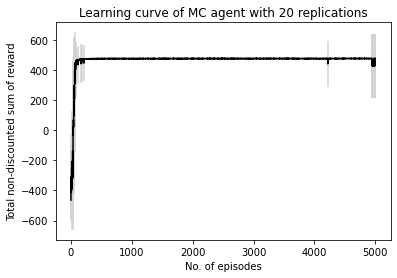

Question 2.5: MC - Impact of different epsilons and alphas
Showing two examples only, uncomment in the code to see other graphs


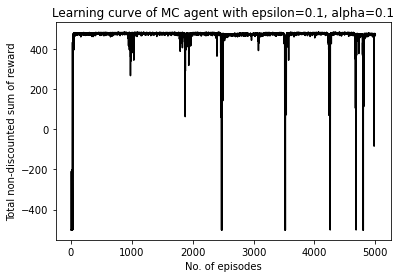

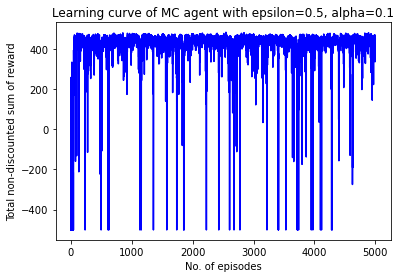

Question 3.3: Learning curve for TD agent (20 replications)


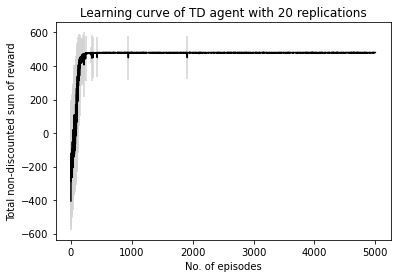

Question 3.4: TD - Impact of different epsilons and alphas
Showing two examples only, uncomment in the code to see other graphs


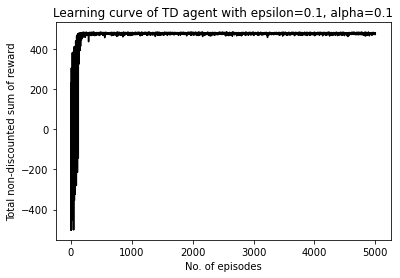

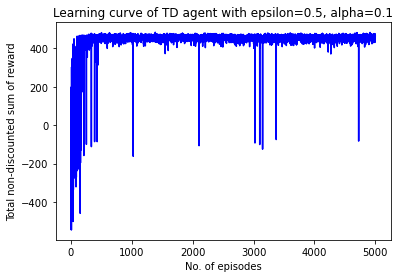

Question 4.1: Estimation Error of both TD and MC learners


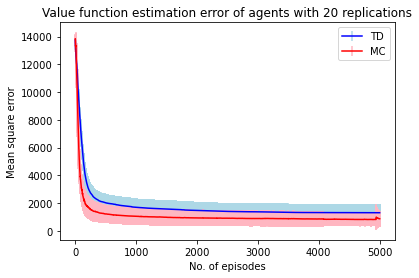

Question 4.3: Scatter plot of TD and MC learners


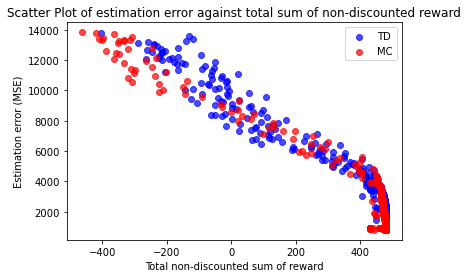

In [8]:
if __name__ == '__main__':
    ### Defining the environment

    print("Creating the Maze:\n")
    maze = Maze()
    print("Probability of success: ", maze._prob_success)
    print("Gamma: ", maze._gamma)
    print("Reward state: ", maze._goal)
    print()
    
    ### Dynamic programming

    dp_grid = DP_agent()
    dp_policy, dp_value = dp_grid.solve(maze)

    print("Results of the DP agent:\n")
    maze.get_graphics().draw_policy(dp_policy)
    maze.get_graphics().draw_value(dp_value)

    
    ### Monte-Carlo learning

    mc_grid = MC_agent()
    mc_policy, mc_values, total_rewards = mc_grid.solve(maze)

    print("Results of the MC agent:\n")
    maze.get_graphics().draw_policy(mc_policy)
    maze.get_graphics().draw_value(mc_values[-1])


    ### Temporal-Difference learning

    td_grid = TD_agent()
    td_policy, td_values, total_rewards = td_grid.solve(maze)

    print("Results of the TD agent:\n")
    maze.get_graphics().draw_policy(td_policy)
    maze.get_graphics().draw_value(td_values[-1])
    
    
###### Generating other plots for analysis ######
# MC learning curve (with replications)
# MC varying epsilon and alpha
# TD learning curve (with replications)
# TD varying epsilon and alpha 
# Estimation error of MC and TD (with replications)
    
    def l_curve_plot(nEpisodes, nReplications, y, yerr, learner):
        x = np.linspace(0, nEpisodes, nEpisodes)
        plt.errorbar(x, y, yerr=yerr, fmt='-', color='black',
                         ecolor='lightgray', capsize=0)
        plt.xlabel('No. of episodes')
        plt.ylabel('Total non-discounted sum of reward')
        plt.title('Learning curve of '+learner+' agent with '+str(nReplications)+ ' replications')
        plt.show()

    def vary_e_a(maze, agent_name, agent, epsilon, alpha, color):
        _, _, total_rewards = agent.solve_param(maze, epsilon, alpha)
        plt.plot(total_rewards, color = color)
        plt.xlabel('No. of episodes')
        plt.ylabel('Total non-discounted sum of reward')
        plt.title('Learning curve of '+agent_name+' agent with epsilon='+str(epsilon)+', alpha='+str(alpha))
        plt.show()
        
    # initialization
    nEpisodes = 5000 # number of episodes (same as the one defined in MC and TD class)
    nReplications = 20 # number of replications
    
    # for learning curve 
    l_curve_mc = []
    l_curve_td = []

    l_curve_mean_mc = []
    l_curve_std_mc = []
    l_curve_mean_td = []
    l_curve_std_td = []
    
    # for MSE
    mc_mses = [] 
    td_mses = []
    
    mses_mean_mc = []
    mses_std_mc = []
    mses_mean_td = []
    mses_std_td = []
    
    for epi in range(nEpisodes):
        l_curve_mc.append(np.zeros((nReplications)))
        l_curve_td.append(np.zeros((nReplications)))
        mc_mses.append([])
        td_mses.append([])

    for i in range(nReplications): 
        print('Replication: ', i)
        _, mc_values, mc_total_rewards = mc_grid.solve(maze) 
        _, td_values, td_total_rewards = td_grid.solve(maze)

        for epi in range(nEpisodes):
            l_curve_mc[epi][i] = mc_total_rewards[epi]
            l_curve_td[epi][i] = td_total_rewards[epi]

            mc_mse = mean_squared_error(dp_value, mc_values[epi], squared=True)
            td_mse = mean_squared_error(dp_value, td_values[epi], squared=True)

            mc_mses[epi].append(mc_mse)
            td_mses[epi].append(td_mse)

    print('Finished Learning...')
    print('Plotting...')

    for i in range(len(l_curve_mc)):

        episode_mean_mc = np.mean(l_curve_mc[i])
        episode_std_mc = np.std(l_curve_mc[i])
        episode_mean_td = np.mean(l_curve_td[i])
        episode_std_td = np.std(l_curve_td[i])

        l_curve_mean_mc.append(episode_mean_mc)
        l_curve_std_mc.append(episode_std_mc)
        l_curve_mean_td.append(episode_mean_td)
        l_curve_std_td.append(episode_std_td)

        mse_episode_mean_mc = np.mean(mc_mses[i])
        mse_episode_std_mc = np.std(mc_mses[i])
        mse_episode_mean_td = np.mean(td_mses[i])
        mse_episode_std_td = np.std(td_mses[i])

        mses_mean_mc.append(mse_episode_mean_mc)
        mses_std_mc.append(mse_episode_std_mc)
        mses_mean_td.append(mse_episode_mean_td)
        mses_std_td.append(mse_episode_std_td)


    print('Learning curve for MC agent ('+str(nReplications)+' replications)')
    l_curve_plot(nEpisodes, nReplications, l_curve_mean_mc, l_curve_std_mc, 'MC')
    
    
    print('MC - Impact of different epsilons and alphas')
    vary_e_a(maze, 'MC', mc_grid, 0.1, 0.1, 'black')
    vary_e_a(maze, 'MC', mc_grid, 0.5, 0.1, 'blue')
    # Uncomment the following to plot other graphs - learning is super slow for them...
#     vary_e_a(maze, 'MC', mc_grid, 0.8, 0.1, 'red') 
#     vary_e_a(maze, 'MC', mc_grid, 0.1, 0.5, 'blue') # used another graph for decayed epsilon for report
#     vary_e_a(maze, 'MC', mc_grid, 0.1, 0.8, 'red') # used another graph for decayed epsilon for report
    
    
    print('Learning curve for TD agent ('+str(nReplications)+' replications)')
    l_curve_plot(nEpisodes, nReplications, l_curve_mean_td, l_curve_std_td, 'TD')

    
    print('TD - Impact of different epsilons and alphas')
    vary_e_a(maze, 'TD', td_grid, 0.1, 0.1, 'black')
    vary_e_a(maze, 'TD', td_grid, 0.5, 0.1, 'blue')
    # Uncomment the following to plot other graphs - learning is super slow for them...
#     vary_e_a(maze, 'TD', td_grid, 0.8, 0.1, 'red')
#     vary_e_a(maze, 'TD', td_grid, 0.1, 0.5, 'blue') # used another graph for decayed epsilon for report
#     vary_e_a(maze, 'TD', td_grid, 0.1, 0.8, 'red') # used another graph for decayed epsilon for report
    

    print('Estimation Error of both TD and MC learners')
    x = np.linspace(0, nEpisodes, nEpisodes)
    plt.errorbar(x, mses_mean_td, yerr=mses_std_td, fmt='-', color='blue',
                         ecolor='lightblue', capsize=0)
    plt.errorbar(x, mses_mean_mc, yerr=mses_std_mc, fmt='-', color='red',
                         ecolor='lightpink', capsize=0)
    plt.xlabel('No. of episodes')
    plt.ylabel('Mean square error')
    plt.legend(['TD', 'MC'])
    plt.title('Value function estimation error of agents with '+str(nReplications)+ ' replications')
    plt.show()